In [1]:
import numpy as np
import pandas as pd
from pandas_analysis import *
import matplotlib.pyplot as plt
from methods_from_spark import *
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def calculate_metrics(y_true, y_pred, title):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"Metrics for {title}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    

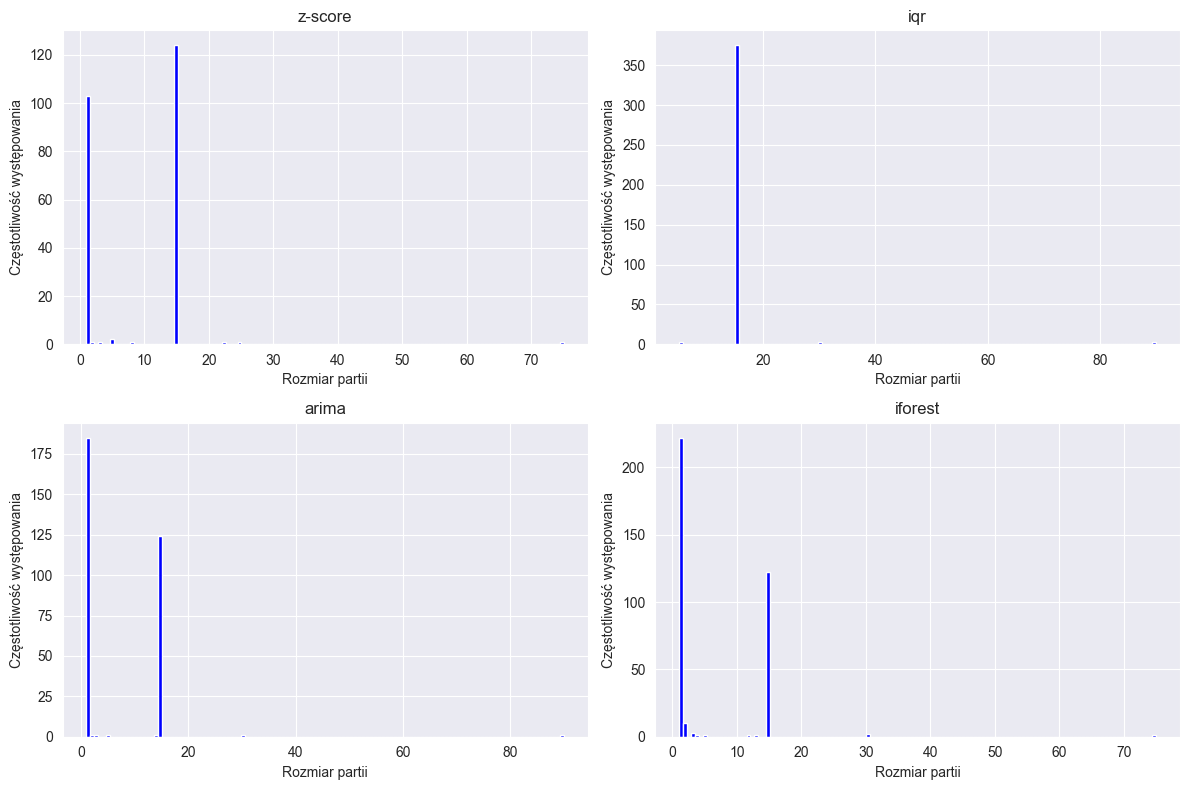

In [3]:
df_z_score = pd.read_csv('data/z-score/combined_15min.csv')
df_iqr_score = pd.read_csv('data/iqr/combined_15min.csv')
df_arima_score = pd.read_csv('data/arima/combined_15min.csv')
df_iforest_score = pd.read_csv('data/iforest/combined_15min.csv')

titles = ["z-score", "iqr", "arima", "iforest"]
batch_statistics_and_plots(df_z_score, df_iqr_score, df_arima_score, df_iforest_score, titles=titles, x_label="Rozmiar partii", y_label="Częstotliwość występowania")

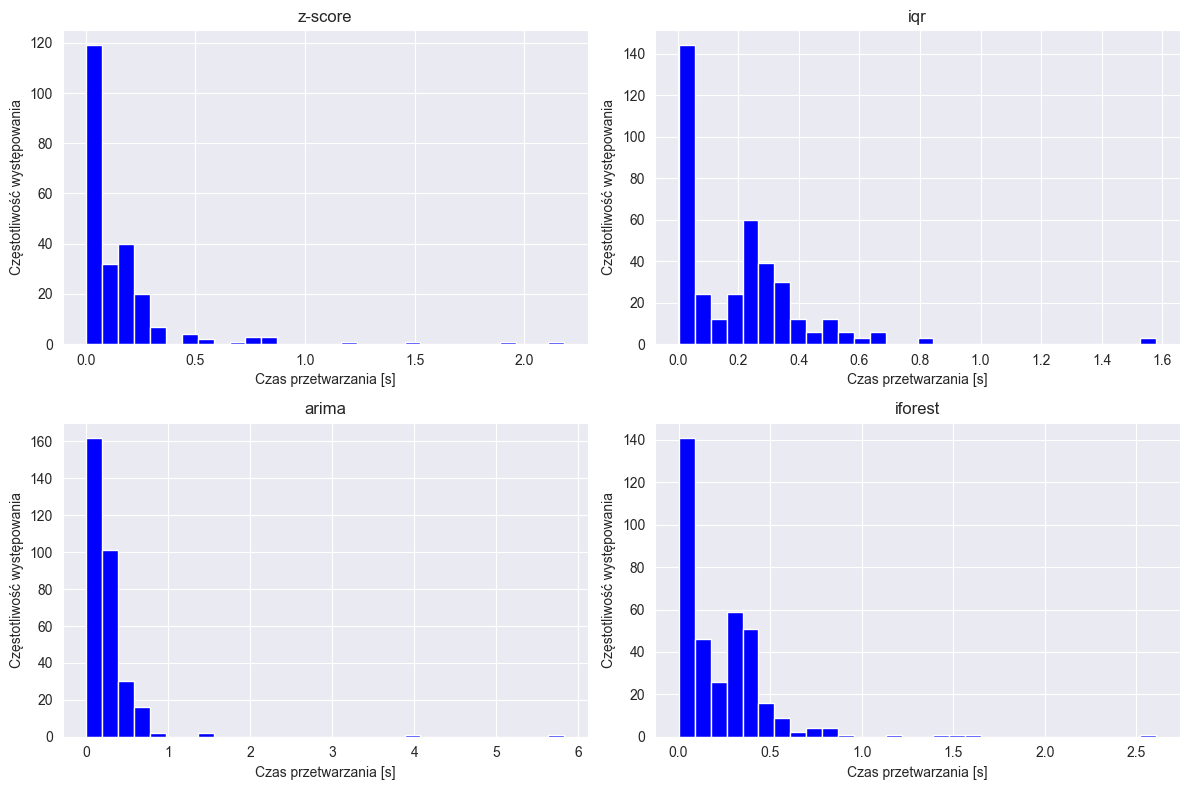

In [4]:
plot_ingestion_time_stats(df_z_score, df_iqr_score, df_arima_score, df_iforest_score, titles=titles, x_label="Czas przetwarzania [s]", y_label="Częstotliwość występowania")

In [5]:
# plot_confusion_matrix(df_z_score, df_iqr_score, df_arima_score, df_iforest_score, titles=titles)

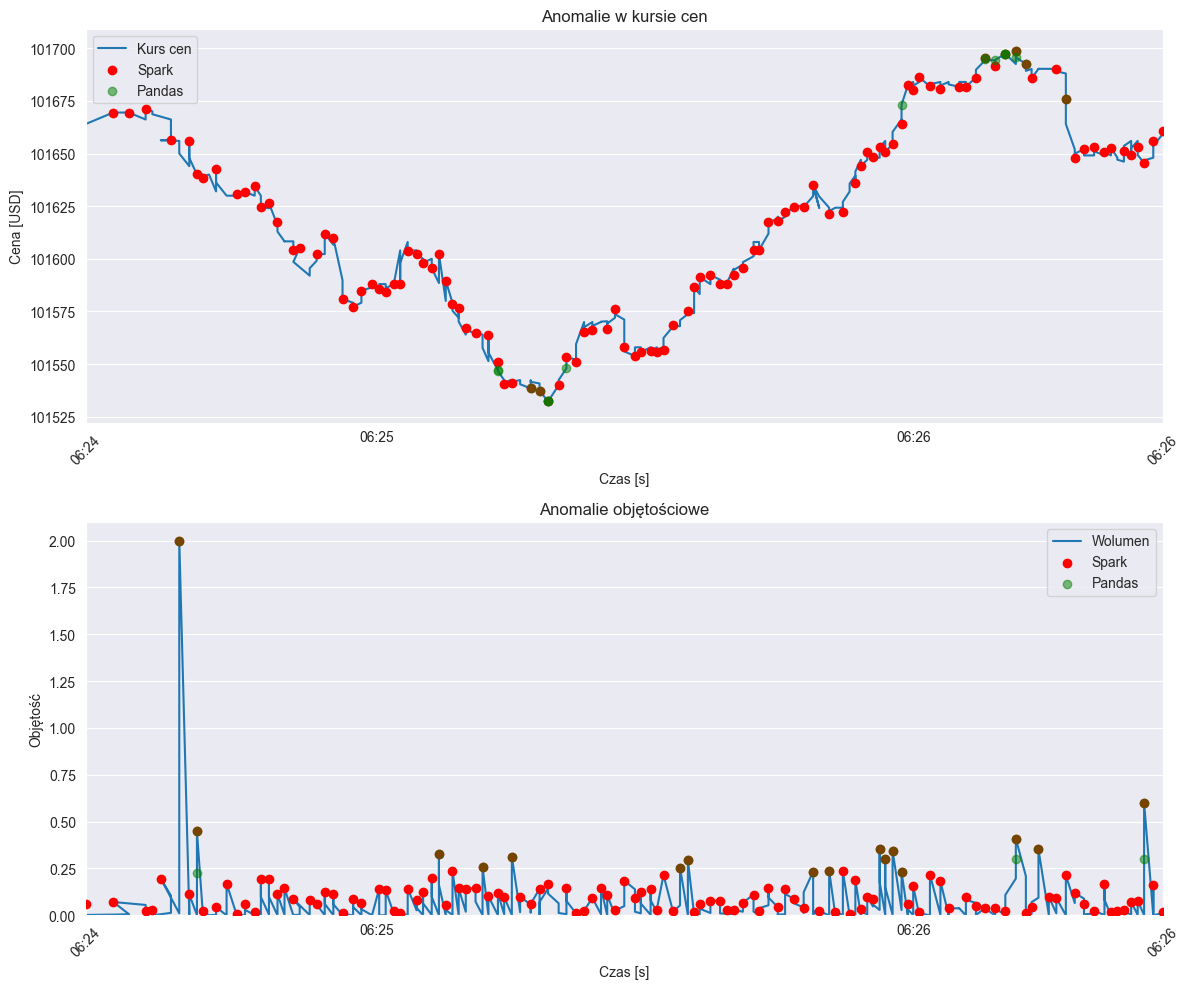

In [6]:
from pandas_analysis import create_method_analysis
create_method_analysis(iforest_anomalies, df_iforest_score, title="Wyniki iForest", iforest=True)

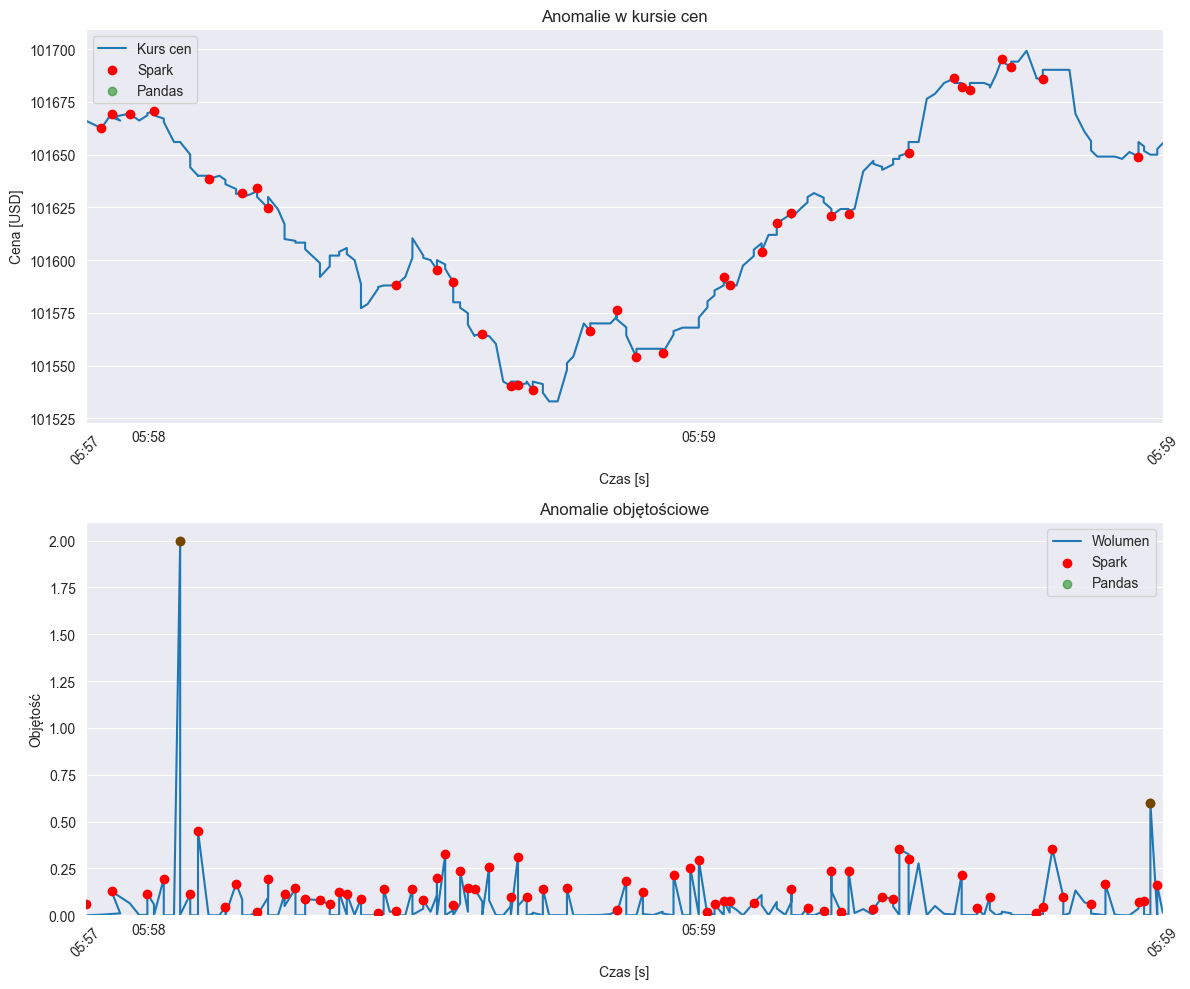

In [7]:
create_method_analysis(z_score_anomalies, df_z_score, title="", iforest=True)

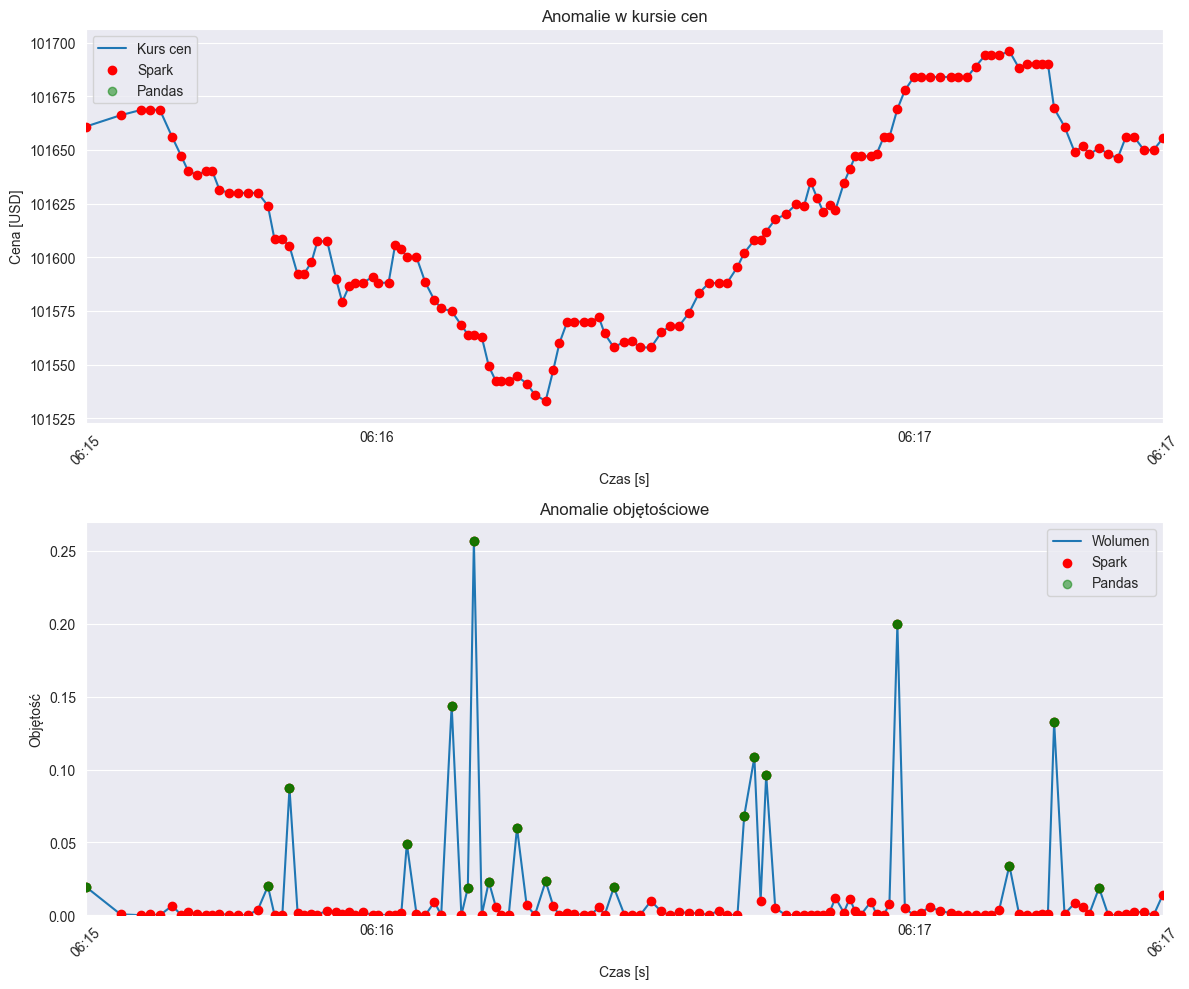

In [8]:
create_method_analysis(iqr_anomalies, df_iqr_score, title="", iforest=True)

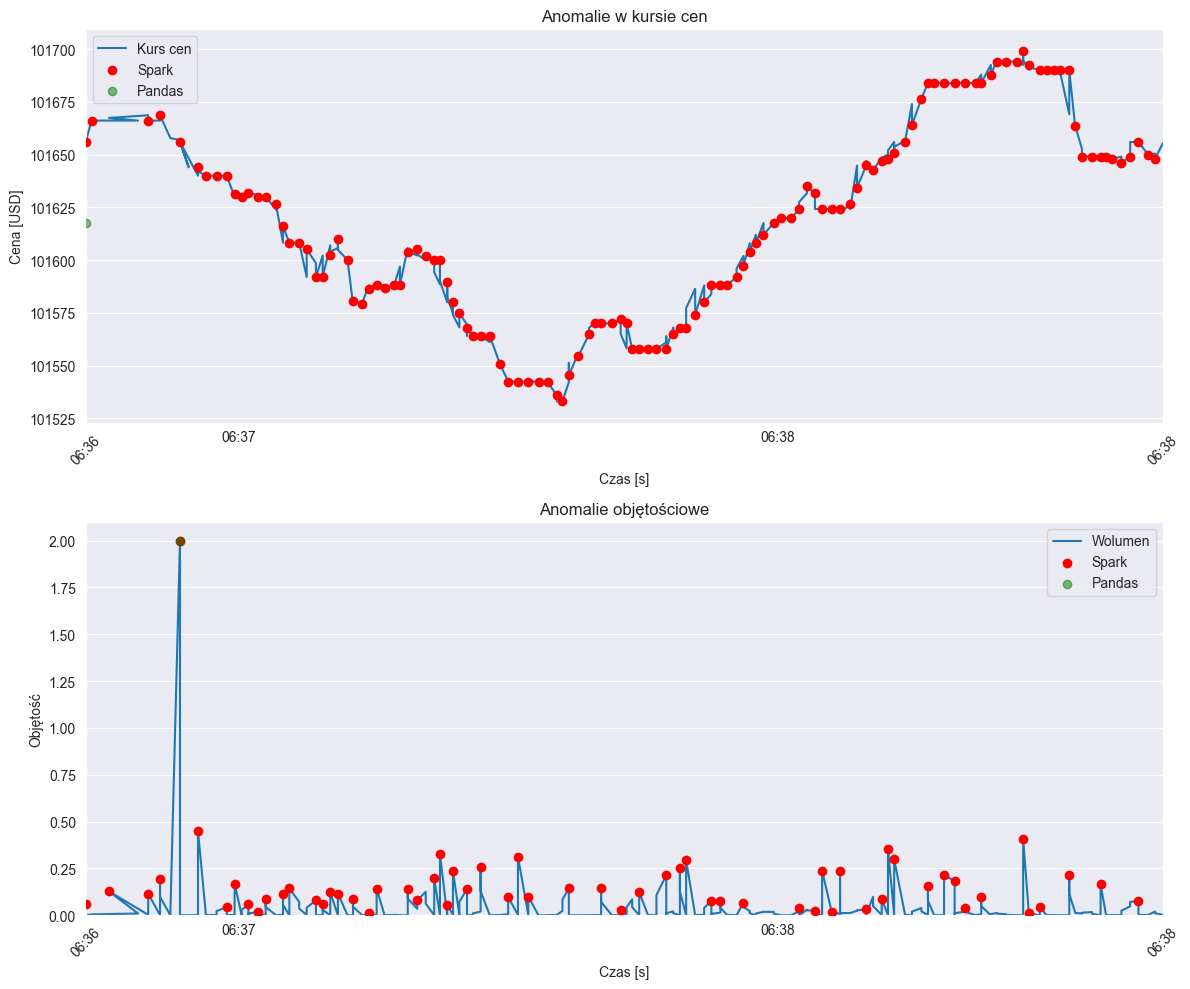

In [9]:
create_method_analysis(arima_anomalies, df_arima_score, iforest=True)